Iteration 1/10, Error: 0.2084, Alpha: 0.6672
Iteration 2/10, Error: 0.4864, Alpha: 0.0272
Iteration 3/10, Error: 0.5424, Alpha: -0.0850
Iteration 4/10, Error: 0.3721, Alpha: 0.2615
Iteration 5/10, Error: 0.2708, Alpha: 0.4952
Iteration 6/10, Error: 0.4086, Alpha: 0.1848
Iteration 7/10, Error: 0.4823, Alpha: 0.0355
Iteration 8/10, Error: 0.5830, Alpha: -0.1676
Iteration 9/10, Error: 0.1744, Alpha: 0.7773
Iteration 10/10, Error: 0.3405, Alpha: 0.3305
Final Accuracy: 0.79
AUC Score for Class 1: 0.94
AUC Score for Class 2: 0.65
AUC Score for Class 3: 0.66
AUC Score for Class 4: 0.90
AUC Score for Class 5: 1.00
AUC Score for Class 6: 0.14
Average AUC Score: 0.71


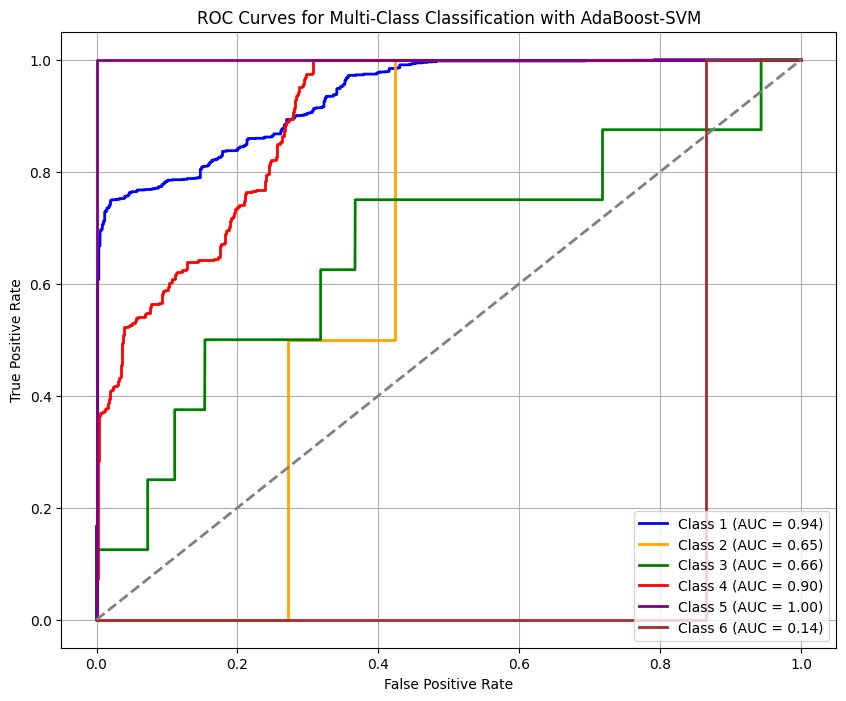

In [1]:
# Step 1: Install Required Libraries (if not already installed)
!pip install scikit-learn pandas matplotlib

# Step 2: Import Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import random

np.random.seed(4)
random.seed(4)

# Step 3: Load the Dataset
dataset_url = 'https://raw.githubusercontent.com/Fillipedem/UCI-Statlog-Shuttle/master/data/shuttle.tst'
column_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'class']  # Adjust column names as needed
df = pd.read_csv(dataset_url, sep='\s+', header=None, names=column_names)

# Step 4: Preprocess the Data
X = df.drop('class', axis=1)
y = df['class']

# Step 5: Split the Data into Training and Test Sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 6: Define the AdaBoost-SVM Function
def adaboost_svm(X_train, y_train, X_test, y_test, n_estimators=50):
    n_samples, n_features = X_train.shape
    # Initialize weights uniformly
    w = np.ones(n_samples) / n_samples
    classifiers = []
    alpha_values = []

    for i in range(n_estimators):
        # Step 6.1: Train an SVM classifier with the weighted data
        svm = SVC(probability=True, kernel='rbf', C=1.0, random_state=42)
        svm.fit(X_train, y_train, sample_weight=w)

        # Step 6.2: Get predictions and calculate the error
        y_pred = svm.predict(X_train)
        incorrect = (y_pred != y_train)
        error = np.dot(w, incorrect) / np.sum(w)

        # Step 6.3: Calculate the classifier's weight (alpha)
        # Adding a small epsilon to avoid division by zero
        epsilon = 1e-10
        alpha = 0.5 * np.log((1 - error + epsilon) / (error + epsilon))
        alpha_values.append(alpha)
        classifiers.append(svm)

        # Step 6.4: Update weights
        w *= np.exp(-alpha * y_train * (2 * (y_pred == y_train) - 1))
        w /= np.sum(w)  # Normalize weights

        # Print progress
        print(f'Iteration {i + 1}/{n_estimators}, Error: {error:.4f}, Alpha: {alpha:.4f}')

    # Step 7: Make Final Predictions
    final_pred = np.zeros(len(X_test))
    for alpha, clf in zip(alpha_values, classifiers):
        final_pred += alpha * clf.predict(X_test)
    final_pred = np.sign(final_pred)

    # Step 8: Evaluate Model Performance
    accuracy = accuracy_score(y_test, final_pred)
    print(f'Final Accuracy: {accuracy:.2f}')

    # Calculate AUC for each class (if possible)
    y_pred_proba = np.array([alpha * clf.predict_proba(X_test) for alpha, clf in zip(alpha_values, classifiers)]).sum(axis=0)
    auc_scores = {}
    for class_label in np.unique(y_train):
        if class_label in y_test.values:
            auc_scores[class_label] = roc_auc_score(y_test == class_label, y_pred_proba[:, list(np.unique(y_train)).index(class_label)])

    # Print AUC for each class
    for class_label, auc in auc_scores.items():
        print(f"AUC Score for Class {class_label}: {auc:.2f}")

    # Calculate the overall AUC by averaging class AUCs
    average_auc = np.mean(list(auc_scores.values()))
    print(f"Average AUC Score: {average_auc:.2f}")

    # Step 9: Plot the ROC Curves for each class
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    # Calculate ROC curves for each class
    for idx, class_label in enumerate(np.unique(y_train)):
        if class_label in y_test.values:
            fpr, tpr, _ = roc_curve(y_test == class_label, y_pred_proba[:, idx])
            plt.plot(fpr, tpr, color=colors[idx % len(colors)], lw=2, label=f'Class {class_label} (AUC = {auc_scores[class_label]:.2f})')

    # Plot the diagonal line (chance level)
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multi-Class Classification with AdaBoost-SVM')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    return classifiers, alpha_values

# Step 10: Run the AdaBoost-SVM Model
classifiers, alpha_values = adaboost_svm(X_train, y_train, X_test, y_test, n_estimators=10)


Iteration 1/10, Error: 0.3463, Alpha: 0.3177
Iteration 2/10, Error: 0.4212, Alpha: 0.1588
Iteration 3/10, Error: 0.4604, Alpha: 0.0794
Iteration 4/10, Error: 0.4802, Alpha: 0.0397
Iteration 5/10, Error: 0.4901, Alpha: 0.0199
Iteration 6/10, Error: 0.4950, Alpha: 0.0099
Iteration 7/10, Error: 0.4975, Alpha: 0.0050
Iteration 8/10, Error: 0.4988, Alpha: 0.0025
Iteration 9/10, Error: 0.4994, Alpha: 0.0012
Iteration 10/10, Error: 0.4997, Alpha: 0.0006
Final Accuracy: 0.65
AUC Score: 0.78


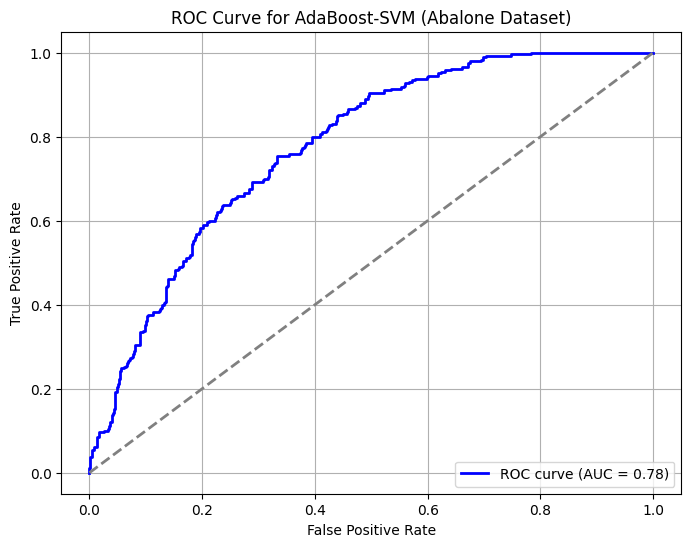

In [4]:
# Step 1: Install Required Libraries (if not already installed)
# !pip install scikit-learn pandas matplotlib

# Step 2: Import Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import random

np.random.seed(4)
random.seed(4)

# Step 3: Load the Abalone Dataset
dataset_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
column_names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']
df = pd.read_csv(dataset_url, header=None, names=column_names)

# Step 4: Preprocess the Data
# Convert categorical 'Sex' feature using Label Encoding
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])

# Set 'Rings' as the target variable (age) and others as features.
X = df.drop('Rings', axis=1)
y = df['Rings']

# Standardize the feature values to improve SVM performance
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Step 5: Convert target variable into binary classes for simplicity in SVM.
# Here, we will categorize 'Rings' into "Young" (<=10) and "Old" (>10).
y = np.where(y <= 10, 0, 1)  # 0 for "Young", 1 for "Old"

# Step 6: Split the Data into Training and Test Sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 7: Define the AdaBoost-SVM Function
def adaboost_svm(X_train, y_train, X_test, y_test, n_estimators=50):
    n_samples, n_features = X_train.shape
    # Initialize weights uniformly
    w = np.ones(n_samples) / n_samples
    classifiers = []
    alpha_values = []

    for i in range(n_estimators):
        # Step 7.1: Train an SVM classifier with the weighted data
        svm = SVC(probability=True, kernel='rbf', C=1.0, random_state=42)
        svm.fit(X_train, y_train, sample_weight=w)

        # Step 7.2: Get predictions and calculate the error
        y_pred = svm.predict(X_train)
        incorrect = (y_pred != y_train)
        error = np.dot(w, incorrect) / np.sum(w)

        # Step 7.3: Calculate the classifier's weight (alpha)
        # Adding a small epsilon to avoid division by zero
        epsilon = 1e-10
        alpha = 0.5 * np.log((1 - error + epsilon) / (error + epsilon))
        alpha_values.append(alpha)
        classifiers.append(svm)

        # Step 7.4: Update weights
        w *= np.exp(-alpha * y_train * (2 * (y_pred == y_train) - 1))
        w /= np.sum(w)  # Normalize weights

        # Print progress
        print(f'Iteration {i + 1}/{n_estimators}, Error: {error:.4f}, Alpha: {alpha:.4f}')

    # Step 8: Make Final Predictions
    final_pred = np.zeros(len(X_test))
    for alpha, clf in zip(alpha_values, classifiers):
        final_pred += alpha * clf.predict(X_test)
    final_pred = np.sign(final_pred)

    # Step 9: Evaluate Model Performance
    accuracy = accuracy_score(y_test, final_pred)
    print(f'Final Accuracy: {accuracy:.2f}')

    # Calculate AUC for each class (if possible)
    y_pred_proba = np.array([alpha * clf.predict_proba(X_test) for alpha, clf in zip(alpha_values, classifiers)]).sum(axis=0)
    auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])  # Calculate AUC for the binary classification
    print(f"AUC Score: {auc_score:.2f}")

    # Step 10: Plot the ROC Curve for the binary classification
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=2)  # Diagonal line (chance level)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for AdaBoost-SVM (Abalone Dataset)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    return classifiers, alpha_values

# Step 11: Run the AdaBoost-SVM Model
classifiers, alpha_values = adaboost_svm(X_train, y_train, X_test, y_test, n_estimators=10)


In [27]:
!pip install -U scikit-learn

In [67]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import class_weight

# Load Yeast Dataset
url = 'https://raw.githubusercontent.com/mikeizbicki/datasets/master/csv/uci/yeast.data'
column_names = [ 'mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc', 'class']
data = pd.read_csv(url, sep='\s+', header=None, names=column_names)

# Encode the labels
label_encoder = LabelEncoder()
data['class'] = label_encoder.fit_transform(data['class'])

# Preprocess the dataset
X = data.drop(columns=['class'])  # Features
y = data['class']  # Class labels

# Ensure that all features are numeric
X = X.apply(pd.to_numeric, errors='coerce')  # Convert to numeric and coerce errors to NaN
X = X.fillna(X.mean())  # Fill NaN values with the mean of each column

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check class distribution before SMOTE
print("Class distribution before SMOTE:")
print(y_train.value_counts())

# Apply SMOTE for oversampling
smote = SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=42)  # Set k_neighbors <= min samples in minority class
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:")
print(y_resampled.value_counts())

# Apply Random Undersampling to balance the classes
rus = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = rus.fit_resample(X_resampled, y_resampled)

# Initialize SVM with class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_balanced), y=y_balanced)
class_weight_dict = dict(enumerate(class_weights))

# Train SVM model with class weights
svm_model = SVC(kernel='linear', class_weight=class_weight_dict)  # You can also try kernel='rbf'
svm_model.fit(X_balanced, y_balanced)

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred) * 100
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}%')
print('Confusion Matrix:\n', confusion)
print('Classification Report:\n', report)


Class distribution before SMOTE:
class
0    367
7    344
6    192
5    129
4     45
3     36
2     27
9     24
8     18
1      5
Name: count, dtype: int64
Class distribution after SMOTE:
class
0    367
3    367
7    367
9    367
5    367
6    367
4    367
2    367
8    367
1    367
Name: count, dtype: int64
Accuracy: 53.54%
Confusion Matrix:
 [[44  3  0  1  1  5 21  0 21]
 [ 1  6  0  0  1  0  0  0  0]
 [ 0  3  5  0  0  0  0  0  0]
 [ 0  0  2  4  0  0  0  0  0]
 [ 0  0  0  1 26  0  4  0  3]
 [ 6  0  0  2  2 34  2  0  6]
 [26  0  0  3  3  6 37  0 10]
 [ 0  0  0  0  0  0  0  2  0]
 [ 1  3  0  0  0  1  0  0  1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.46      0.51        96
           2       0.40      0.75      0.52         8
           3       0.71      0.62      0.67         8
           4       0.36      0.67      0.47         6
           5       0.79      0.76      0.78        34
           6       0.74      0.65  

Iteration 1/10, Error: 0.1415, Alpha: 0.9014
Iteration 2/10, Error: 0.5000, Alpha: 0.0000
Iteration 3/10, Error: 0.5000, Alpha: 0.0000
Iteration 4/10, Error: 0.5000, Alpha: 0.0000
Iteration 5/10, Error: 0.5000, Alpha: 0.0000
Iteration 6/10, Error: 0.5000, Alpha: 0.0000
Iteration 7/10, Error: 0.5000, Alpha: 0.0000
Iteration 8/10, Error: 0.5000, Alpha: 0.0000
Iteration 9/10, Error: 0.5000, Alpha: 0.0000
Iteration 10/10, Error: 0.5000, Alpha: 0.0000
Final Accuracy: 0.14
AUC Score: 0.50


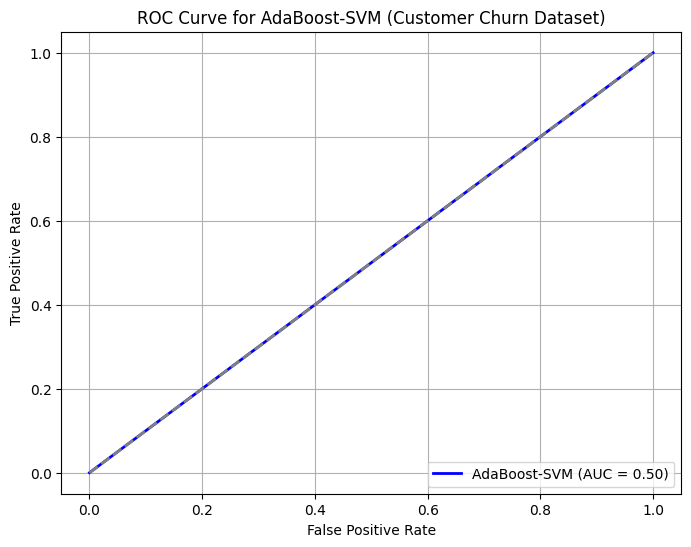

In [16]:
# Step 1: Install Required Libraries (if not already installed)
# !pip install scikit-learn pandas matplotlib

# Step 2: Import Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import random

np.random.seed(4)
random.seed(4)

# Step 3: Load the Customer Churn Dataset
dataset_url = 'https://raw.githubusercontent.com/mahidul5130/ChurnNet_Deep_Learning_Enhanced_Customer_Churn-Prediction_in_Telecommunication_Industry/refs/heads/main/Churn-data-UCI%20Dataset(5000).csv'
df = pd.read_csv(dataset_url)

# Step 4: Preprocess the Data
# Convert 'Churn' to binary (e.g., 0 for 'No', 1 for 'Yes')
df['churn'] = df['churn'].apply(lambda x: 1 if str(x).lower() == 'true' else 0)

# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Impute missing values in numeric columns with the mean
numeric_imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])

# Impute missing values in categorical columns with the most frequent value
categorical_imputer = SimpleImputer(strategy='most_frequent')
#df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

# Handle categorical features using Label Encoding or One-Hot Encoding
df = pd.get_dummies(df, drop_first=True)

# Separate features (X) and target (y)
X = df.drop('churn', axis=1)
y = df['churn']

# Standardize the feature values to improve SVM performance
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Step 5: Split the Data into Training and Test Sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 6: Define the AdaBoost-SVM Function for Binary Classification
def adaboost_svm(X_train, y_train, X_test, y_test, n_estimators=50):
    n_samples, n_features = X_train.shape
    w = np.ones(n_samples) / n_samples  # Initialize weights uniformly
    classifiers = []
    alpha_values = []

    for i in range(n_estimators):
        # Step 6.1: Train an SVM classifier with the weighted data
        svm = SVC(probability=True, kernel='rbf', C=1.0, random_state=42)
        svm.fit(X_train, y_train, sample_weight=w)

        # Step 6.2: Get predictions and calculate the error
        y_pred = svm.predict(X_train)
        incorrect = (y_pred != y_train)
        error = np.dot(w, incorrect) / np.sum(w)

        # Step 6.3: Calculate the classifier's weight (alpha)
        epsilon = 1e-10  # Adding a small epsilon to avoid division by zero
        alpha = 0.5 * np.log((1 - error + epsilon) / (error + epsilon))
        alpha_values.append(alpha)
        classifiers.append(svm)

        # Step 6.4: Update weights
        w *= np.exp(-alpha * (2 * (y_pred == y_train) - 1))
        w /= np.sum(w)  # Normalize weights

        # Print progress
        print(f'Iteration {i + 1}/{n_estimators}, Error: {error:.4f}, Alpha: {alpha:.4f}')

    # Step 7: Make Final Predictions
    final_pred = np.zeros(len(X_test))
    for alpha, clf in zip(alpha_values, classifiers):
        final_pred += alpha * clf.predict_proba(X_test)[:, 1]
    final_pred = (final_pred > 0).astype(int)

    # Step 8: Evaluate Model Performance
    accuracy = accuracy_score(y_test, final_pred)
    print(f'Final Accuracy: {accuracy:.2f}')

    # Calculate AUC
    auc_score = roc_auc_score(y_test, final_pred)
    print(f"AUC Score: {auc_score:.2f}")

    # Step 9: Plot the ROC Curve
    fpr, tpr, _ = roc_curve(y_test, final_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AdaBoost-SVM (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for AdaBoost-SVM (Customer Churn Dataset)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    return classifiers, alpha_values

# Step 10: Run the AdaBoost-SVM Model
classifiers, alpha_values = adaboost_svm(X_train, y_train, X_test, y_test, n_estimators=10)
